# Assignment 1 - LS on 2nd order polynomial

First, we will define the necessary functions and objects to carry out task 1.4. Then, we will examine each sub-case in task 1.4. 

In [1]:
# Imports
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import laplace, norm
from typing import Callable

In [2]:
def arbitrary_poly(params: list) -> Callable:
    """
    Takes the parameters in params and makes them into a polynomial 
        theta_0 + theta_1*x + theta_2*x^2 + ... + theta_n*x^n
    where n is model order and theta_0 is bias. 
    Args:
        params: list on format [theta_0, theta_1, theta_2, ..., theta_n]
    Returns:
        Function with single argument x. 
    """
    poly_model = lambda x: sum([p*(x**i) for i, p in enumerate(params)])
    return poly_model


In [3]:
class GaussParams:
    def __init__(self, mean: float, std: float):
        self.mean = mean
        self.std = std
        self.var = std**2

        # aliases, these are the names used in scipy.stats functions
        self.loc = self.mean
        self.scale = self.std

    def __iter__(self):  # to allow tuple unpacking
        return iter((self.mean, self.std))


class LaplaceParams:
    def __init__(self, mean: float, beta: float):
        self.mean = mean
        self.beta = beta
        
        # aliases, these are the names used in scipy.stats functions
        self.loc = self.mean
        self.scale = self.beta

    def __iter__(self):  # to allow tuple unpacking
        return iter((self.mean, self.beta))


## Measurement noise generation from a chosen distribution
Probability density functions (PDFs):

Gaussian pdf: $P_N(x) = \frac{1}{\sigma\sqrt{2\pi}}e^{-\frac{1}{2}(\frac{x-\mu}{\sigma})^2}$

Laplacian pdf: $P_L(x) = \frac{1}{2b}e^{-\frac{|x-\mu|}{b}}$



In [4]:
def generate_noise(N: int, magnitude: float, alpha: float, gauss_params: GaussParams, laplace_params: LaplaceParams, seed: int = None) -> np.ndarray:
    """
    Generate noise based on the mixture model: alpha * gaussian + (1 - alpha) * laplacian.
    Args:
        N: number of noise points to generate.
        magnitude: the noise amplitude/magnitude.
        alpha: fraction of guassian and laplacian, should be in interval [0, 1].
        gauss_params: mean and std of gaussian distribution
        laplace_params: mean and beta of laplacian distribution
    Returns:
        A list of N noise points.
    """
    if seed is not None:
        np.random.seed(seed)

    if alpha == 1:
        assert gauss_params is not None
        noise = np.random.normal(*gauss_params, N)
    elif alpha == 0:
        assert laplace_params is not None
        noise = np.random.laplace(*laplace_params, N)
    else:
        assert gauss_params is not None
        assert laplace_params is not None
        assert 0 < alpha < 1
        noise = np.zeros((N,))
        for i in range(N):
            r = np.random.uniform(0,1)
            if r <= alpha:
                noise[i] = np.random.normal(*gauss_params)
            else:
                noise[i] = np.random.laplace(*laplace_params)
    noise *= magnitude

    return noise

## Least squares regression - LS
### Given the sampled data we can estimate the underlying polynomial model using LS regression
Solution to a least squares problem is given by the normal equation:  
$\hat{\mathbf{\theta}} = (\mathbf{u}^T\cdot \mathbf{u})^{-1}(\mathbf{u}^T\cdot \mathbf{y})$

&nbsp;

### Step 1 - rewrite the model in matrix form to get the data tensor u

$y_{measured} = \theta_0  + \theta_1 \cdot u^1 + ... + \theta_n \cdot u^n  + noise =   [1 \; u^1 \; .. \; u^n] \cdot [ \theta_0 \; \theta_1 \; .. \; \theta_n ] ^T + noise$

$\mathbf{u} = [1 \; u^1 \; .. \; u^n]$


### Step 2   

calculate $(\mathbf{u}^T \cdot \mathbf{u})^{-1}$


### Step 3  

calculating dot productcalculate $(\mathbf{u}^T \cdot \mathbf{y})$


### Step 4 

solve for $\hat{\mathbf{\theta}} = (\mathbf{u}^T\cdot \mathbf{u})^{-1}(\mathbf{u}^T\cdot \mathbf{y})$



In [5]:
def least_square(u: np.ndarray, y: np.ndarray, n_params: int) -> np.ndarray:
    """
    Uses least sqaure (LS) to make the best fitting list of parameters.
    Args:
        u: data x values, shape = (N_samples,)
        y: data y values, shape = (N_samples,)
        n_params: number of parameters to find
    """
    N = u.shape[0]
    
    # Create data tensor
    u_tensor = np.ones((N,1))
    for i in range(1, n_params):
        u_tensor = np.append(u_tensor, np.power(u.reshape((-1,1)), i), axis=1)

    # Solve for LS params
    u_dot_u = u_tensor.T @ u_tensor
    u_dot_y = u_tensor.T @ y
    # linalg.solve is more numerically stable than linalg.inv and is therefore preferred
    ls_params = np.linalg.solve(u_dot_u, u_dot_y)

    return ls_params


In [6]:
def ls_statistics(
    u: np.ndarray,
    y: np.ndarray, 
    true_params: np.ndarray, 
    ls_params_estimate: np.ndarray) -> tuple:
    """
    Calculate statistics on LS performance. 
    Args:
        u: data points x value.
        y: measured data points (with noise).
        true_params: list of the true parameters.
        ls_params_estimate: list of the LS parameters estimates.
    Returns:
        Tuple on the form 
            (RMSE, d) 
        where d is the Euclidean distance between the true and estimated parameters.
    """
    ls_model = arbitrary_poly(ls_params_estimate)
    rmse = np.sqrt(np.mean( (ls_model(u) - y)**2 ))
    d = np.linalg.norm( ls_params_estimate - np.array(true_params) )

    return rmse, d


## Task 1.4: Set up global parameters for each case

In [7]:
# True model
true_params = [1,-8,4]
n_params = len(true_params)
y_model = arbitrary_poly(true_params)

# Hyperparameters for noise generation
magnitude = 1.2  # noise magnitude
N = 20           # number of samples

# Setup RNG
np.random.seed(0)  # Non-random generation between code executions. Comment out for true random

# Generate data points
range_low = -1
range_high = 1
u = np.sort(np.random.uniform(range_low, range_high, N))
y_true = y_model(u)

## Case 1: $\alpha = 1$ and $\sigma$ is varying

In [8]:
# Parameters
alpha = 1

# Add noise to the generated data points - thus simulating measurement
ls_data = []
sigma_max = 2
for sigma in np.linspace(0, sigma_max, 1000):
    noise = generate_noise(N, magnitude, alpha, GaussParams(0, sigma), None, seed=None)
    y = y_true + noise

    ls_params = least_square(u, y, n_params)
    rmse, d = ls_statistics(u, y, true_params, ls_params)
    ls_data.append((sigma, ls_params, y, d))


[-0.02346982  0.94533022]


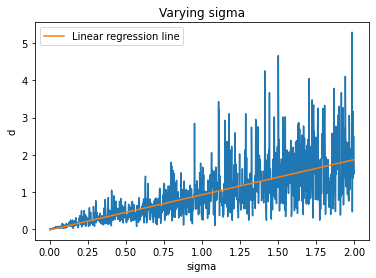

In [9]:
# Plot
sigmas, ds = [], []
for sigma, _, _, d in ls_data:
    sigmas.append(sigma)
    ds.append(d)

sigmas = np.array(sigmas)
lin_reg_line = least_square(sigmas, np.array(ds), 2)
print(lin_reg_line)

plt.figure()
plt.plot(sigmas, ds)
plt.plot(sigmas, arbitrary_poly(lin_reg_line)(sigmas), label="Linear regression line")
plt.xlabel("sigma")
plt.ylabel("d")
plt.title("Varying sigma")
plt.legend()
plt.show()


### Comments to case 1

$\sigma$ is the standard deviation of the Gaussian distribution and determines how "wide" the distribution is. This can be seen in the graph above where $\sigma$ is varying between $0$ and $2$. At low $\sigma$ the LS estimates of the parameters are not spread out much. This tells us that low $\sigma$, meaning low noise, gives a good LS estimate. Increasing $\sigma$, we see clearly that the LS estimates become more varied in precision, meaning that they deviate more from the true parameters. 

There is a clear upwards trend in the data with increasing $\sigma$, and the linear regressin line confirms this point. This is in tune with what we would expect. Larger $\sigma$ means larger spread in the noise which gives a more uncertain estimate. 


## Case 2: $\alpha = 0$ and $\beta$ is varying

In [10]:
# Parameters
alpha = 0

# Add noise to the generated data points - thus simulating measurement
ls_data = []
beta_max = 2
for beta in np.linspace(0, beta_max, 1000):
    noise = generate_noise(N, magnitude, alpha, None, LaplaceParams(0, beta), seed=None)
    y = y_true + noise

    ls_params = least_square(u, y, n_params)
    rmse, d = ls_statistics(u, y, true_params, ls_params)
    ls_data.append((beta, ls_params, y, d))

[-0.03159766  1.34124622]


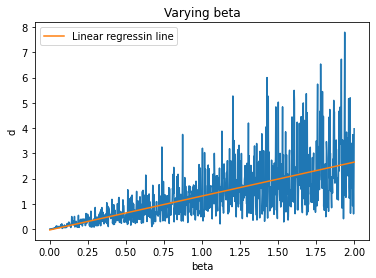

In [11]:
# Plot 
betas, ds = [], []
for beta, params, y, d in ls_data:
    betas.append(beta)
    ds.append(d)

betas = np.array(betas)
lin_reg_line = least_square(betas, np.array(ds), 2)
print(lin_reg_line)

plt.figure()
plt.plot(betas, ds)
plt.plot(betas, arbitrary_poly(lin_reg_line)(betas), label="Linear regressin line")
plt.xlabel("beta")
plt.ylabel("d")
plt.title("Varying beta")
plt.legend()
plt.show()



### Comments to case 2

Similarly to the Gaussian, the $\beta$ parameter determines how wide the Laplacian distribution is. The same points as above can be made for the Laplacian, i.e. that larger $\beta$ leads to poorer LS estimate. Again, we also see a clear upwards trend with increasing $\beta$, which also is expected as larger $\beta$ means wider distriubtion which gives noise values that are more spread out.

An interesting note is that the slope of the linear regression line is here greater than for the Gaussian. This means that increasing $\beta$ will affect the LS estimate more than the same increase in $\sigma$. A possible reason for this is that the covariance of the Gaussian is simply $\sigma^2$, while for the Laplacian it is $2\beta^2$. 


## Case 3: $\sigma = \beta = 1$ and $\alpha$ is varying

In [12]:
# Parameters
gp = GaussParams(0, 1)
lp = LaplaceParams(0, 1)

# Add noise to the generated data points - thus simulating measurement
ls_data = []
for alpha in np.linspace(0,1,1000):
    noise = generate_noise(N, magnitude, alpha, gp, lp, seed=None)
    y = y_true + noise

    ls_params = least_square(u, y, n_params)
    rmse, d = ls_statistics(u, y, true_params, ls_params)
    ls_data.append((alpha, ls_params, y, d))

[ 1.28788062 -0.33508435]


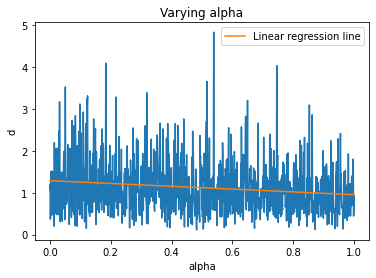

In [13]:
# Plot 
alphas, ds = [], []
for alpha, _, _, d in ls_data:
    alphas.append(alpha)
    ds.append(d)

alphas = np.array(alphas)
lin_reg_line = least_square(alphas, np.array(ds), 2)
print(lin_reg_line)

plt.figure()
plt.plot(alphas, ds)
plt.plot(alphas, arbitrary_poly(lin_reg_line)(alphas), label="Linear regression line")
plt.xlabel("alpha")
plt.ylabel("d")
plt.title("Varying alpha")
plt.legend()
plt.show()


### Comments to case 3 

Looking at the raw data (blue plot), it is hard to make out any clear trend, but the linear regression line has a negative slope. Since greater $\alpha$ means a greater probability of having more Gaussian noise, the negative slope means that the LS estimate becomes slightly better with more Gaussian noise than with more Laplacian noise. However, the difference is not too pronounced. Above we saw that pure Gaussian noise has better performance than pure Laplacian noise. Combined with the negative slope we see here, we can conclude that Gaussian noise is preferred since it gives a slightly better LS estimate (most of the time). 

In fact, it is known that the LS estimate when we have Gaussian noise is the same as the Maximum Likelihood estimate, so this solidifies the conclusion that Gaussian noise is preferred. 